In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
import tonic
import tonic.transforms as transforms
from tonic.transforms import ToFrame
import os

c:\Users\mahia\miniconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
N_FRAMES = 60

# ===== CRITICAL: Set all random seeds FIRST =====
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Worker init function for DataLoader reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Generator for DataLoader
g = torch.Generator()
g.manual_seed(42)

In [3]:
class DVSGestureNumpyDataset(Dataset):
    def __init__(self, root_dir='newdata/DVSGesture', train=True, transform=None):
        self.transform = transform
        self.samples = []
        
        split = 'ibmGestureTrain' if train else 'ibmGestureTest'
        split_dir = os.path.join(root_dir, split)
        
        if not os.path.exists(split_dir):
            raise FileNotFoundError(f"Not found: {split_dir}")
        
        print(f"Scanning {split_dir} ...")
        for user_folder in sorted(os.listdir(split_dir)):
            user_path = os.path.join(split_dir, user_folder)
            if not os.path.isdir(user_path): 
                continue
            for file in sorted(os.listdir(user_path)):
                if file.endswith('.npy'):
                    path = os.path.join(user_path, file)
                    label = int(os.path.splitext(file)[0])
                    self.samples.append((path, label))
        
        print(f"Found {len(self.samples)} samples in {split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        events = np.load(path)

        # ===== CRITICAL FIX: Your data format is [x, y, p, t] not [t, x, y, p] =====
        if events.dtype.names is None:
            # Plain numpy array with shape (N, 4)
            # Your format: column 0=x, 1=y, 2=p, 3=t
            x = events[:, 0]
            y = events[:, 1]
            p = events[:, 2]
            t = events[:, 3]
        else:
            # Structured array
            t = events['t']
            x = events['x']
            y = events['y']
            p = events['p']

        # Your timestamps are already normalized to [0,1], need to convert to microseconds
        # Typical DVSGesture recordings are ~6 seconds, so multiply by 6e6
        # This gives timestamps in microseconds which Tonic expects
        t_us = t * 6e6  # Convert normalized [0,1] to microseconds
        
        # Your polarity values are already 0 and 1 (correct format)
        # No need to clip
        
        # Rebuild as proper structured array with CORRECT ORDER: t, x, y, p
        events = np.rec.fromarrays(
            [
                t_us.astype(np.float64),    # timestamps in microseconds
                x.astype(np.int16),         # x coordinates
                y.astype(np.int16),         # y coordinates  
                p.astype(np.int16)          # polarity (0 or 1)
            ], 
            names='t,x,y,p'
        )

        if self.transform:
            frames = self.transform(events)
        else:
            frames = events

        return frames, torch.tensor(label, dtype=torch.long)


In [4]:
# Transform
frame_transform = ToFrame(
    sensor_size=(128, 128, 2),
    n_time_bins=N_FRAMES
)

In [5]:
# Datasets
train_dataset = DVSGestureNumpyDataset(train=True, transform=frame_transform)
test_dataset = DVSGestureNumpyDataset(train=False, transform=frame_transform)

Scanning newdata/DVSGesture\ibmGestureTrain ...
Found 1077 samples in ibmGestureTrain
Scanning newdata/DVSGesture\ibmGestureTest ...
Found 264 samples in ibmGestureTest


In [6]:
# Loaders with reproducibility settings
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True,
    num_workers=0, 
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False,
    num_workers=0, 
    pin_memory=True
)

In [7]:
frames, labels = next(iter(train_loader))
frames = frames.permute(0, 2, 1, 3, 4)  # (B, 2, T, 128, 128)

In [8]:
class Gesture3DCNN(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()
        self.conv1 = nn.Conv3d(2, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d((1, 2, 2))

        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d((2, 2, 2))

        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.pool3 = nn.MaxPool3d((2, 2, 2))

        self.dropout = nn.Dropout(p=0.3)
        self.gap = nn.AdaptiveAvgPool3d((1, 4, 4))
        self.fc = nn.Linear(128 * 1 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [9]:
# Initialize model
model = Gesture3DCNN(num_classes=11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

scaler = GradScaler(enabled=torch.cuda.is_available())
EPOCHS = 20
history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for frames, labels in loader:
            frames = frames.permute(0, 2, 1, 3, 4).float().to(device)
            max_vals = frames.amax(dim=(2, 3, 4), keepdim=True)
            frames = frames / (max_vals + 1e-6)
            labels = labels.to(device)
            logits = model(frames)
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return correct / total

best_acc, best_state = 0.0, None
patience, waited = 5, 0

print("\n" + "="*60)
print("Starting Training")
print("="*60)

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for frames, labels in train_loader:
        frames = frames.permute(0, 2, 1, 3, 4).float().to(device)
        max_vals = frames.amax(dim=(2, 3, 4), keepdim=True)
        frames = frames / (max_vals + 1e-6)
        labels = labels.to(device)

        optimizer.zero_grad()
        with autocast(enabled=torch.cuda.is_available()):
            logits = model(frames)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * frames.size(0)
        correct += (logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    test_acc = evaluate_accuracy(model, test_loader)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)

    # LR schedule on validation metric
    scheduler.step(test_acc)

    # Save best and early stop
    if test_acc > best_acc:
        best_acc = test_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        waited = 0
        torch.save({'state_dict': best_state, 'acc': best_acc}, 'best_dvsgesture_3dcnn.pth')
    else:
        waited += 1

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | LR: {optimizer.param_groups[0]['lr']:.1e}")

    if waited >= patience:
        print(f"\nEarly stopping triggered. Best Test Acc: {best_acc:.3f}")
        break

# Restore best weights
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    print(f"Restored best model with Test Acc: {best_acc:.3f}")

C:\Users\mahia\AppData\Local\Temp\ipykernel_26880\3143241507.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())



Starting Training


C:\Users\mahia\AppData\Local\Temp\ipykernel_26880\3143241507.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 01 | Train Loss: 1.2540 | Train Acc: 0.524 | Test Acc: 0.583 | LR: 1.0e-03
Epoch 02 | Train Loss: 0.7872 | Train Acc: 0.731 | Test Acc: 0.788 | LR: 1.0e-03
Epoch 03 | Train Loss: 0.4949 | Train Acc: 0.826 | Test Acc: 0.818 | LR: 1.0e-03
Epoch 04 | Train Loss: 0.4162 | Train Acc: 0.864 | Test Acc: 0.754 | LR: 1.0e-03
Epoch 05 | Train Loss: 0.3387 | Train Acc: 0.897 | Test Acc: 0.788 | LR: 1.0e-03
Epoch 06 | Train Loss: 0.2950 | Train Acc: 0.895 | Test Acc: 0.837 | LR: 1.0e-03
Epoch 07 | Train Loss: 0.2389 | Train Acc: 0.920 | Test Acc: 0.894 | LR: 1.0e-03
Epoch 08 | Train Loss: 0.2011 | Train Acc: 0.938 | Test Acc: 0.886 | LR: 1.0e-03
Epoch 09 | Train Loss: 0.1826 | Train Acc: 0.944 | Test Acc: 0.795 | LR: 1.0e-03
Epoch 10 | Train Loss: 0.1812 | Train Acc: 0.946 | Test Acc: 0.883 | LR: 5.0e-04
Epoch 11 | Train Loss: 0.1297 | Train Acc: 0.963 | Test Acc: 0.917 | LR: 5.0e-04
Epoch 12 | Train Loss: 0.1100 | Train Acc: 0.963 | Test Acc: 0.924 | LR: 5.0e-04
Epoch 13 | Train Loss: 0.093

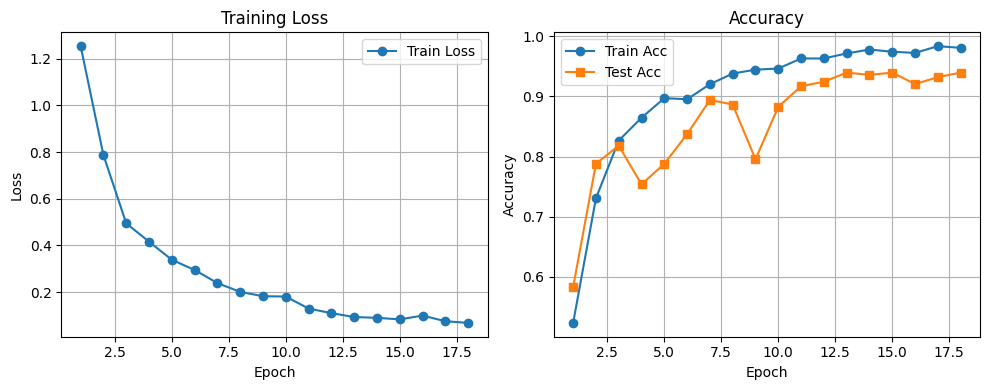

In [16]:
# Plot training history
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Acc', marker='o')
plt.plot(epochs, history['test_acc'], label='Test Acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Test single sample
model.eval()
with torch.no_grad():
    sample_frames, sample_label = test_dataset[0]
    x = torch.tensor(sample_frames).unsqueeze(0)
    x = x.permute(0, 2, 1, 3, 4).float().to(device)
    x = x / (x.amax(dim=(2, 3, 4), keepdim=True) + 1e-6)
    logits = model(x)
    pred = logits.argmax(1).item()

print(f"\nSingle sample test:")
print(f"True label: {sample_label}, Predicted: {pred}")


Single sample test:
True label: 0, Predicted: 9


In [18]:
# Full evaluation
all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    for frames, labels in test_loader:
        frames = frames.permute(0, 2, 1, 3, 4).float().to(device)
        max_vals = frames.amax(dim=(2, 3, 4), keepdim=True)
        frames = frames / (max_vals + 1e-6)
        labels = labels.to(device)
        logits = model(frames)
        preds = logits.argmax(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

In [13]:
# Classification report
print("\n" + "="*60)
print("Classification Report")
print("="*60)
print(classification_report(all_labels, all_preds))


Classification Report
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        24
           1       1.00      1.00      1.00        24
           2       0.96      1.00      0.98        24
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        24
           7       1.00      0.88      0.93        24
           8       0.89      0.67      0.76        24
           9       0.96      0.92      0.94        24
          10       0.88      0.96      0.92        24

    accuracy                           0.94       264
   macro avg       0.95      0.94      0.94       264
weighted avg       0.95      0.94      0.94       264



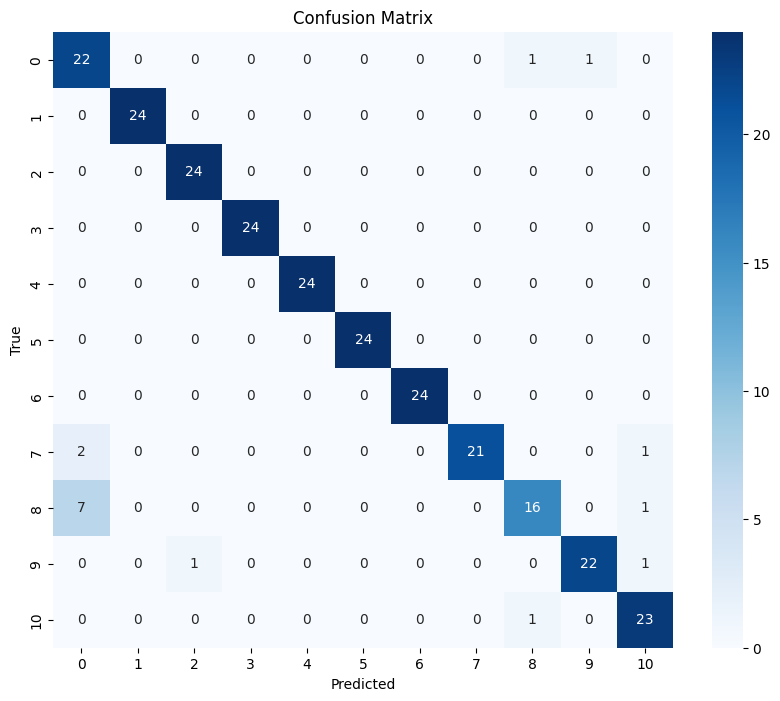

In [14]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()